### Transformer decoder

This notebook contains implementation of Transformer decoder only that, OpenAI
have use as a core model for GPT-2 [Paper](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)

This implementation is for educational purposes only.

I will try to feed this model with the data i have used for RNN, GRU and MLP models that I previously created.

In [46]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from math import sqrt
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

@dataclass
class NetworkConfig:
    c_embedding: int = 64 # C.shape --> 27 X 20
    vocab_size: int = 27
    batch_size: int = 1024
    input_weights: int = 1000# Wx.shape --> 20 x 1000; Wx @ x_t --> 512 x 1000
    tanh_gain: float = 5 / 3
    block_size: int = 16
    dropout: float = 0.3

According to [Transformer]() paper we are creating possitional embeddings, such that:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)$$

As an example, suppose we have a transformer model that takes as input a sequence of 5 tokens, each represented by a 4-dimensional embedding vector. The positional encoding for the first token would be:

$$PE_{(1, 0)} = \sin\left(\frac{1}{10000^{0/4}}\right) = 0$$

$$PE_{(1, 1)} = \cos\left(\frac{1}{10000^{0/4}}\right) = 1$$

$$PE_{(1, 2)} = \sin\left(\frac{1}{10000^{2/4}}\right) = 0.0998$$

$$PE_{(1, 3)} = \cos\left(\frac{1}{10000^{2/4}}\right) = 0.995$$

In [47]:
def positional_encoding(data: torch.Tensor, device: str = 'cpu') -> torch.Tensor:
    assert len(data.shape) == 3, "Tensor must be of dimmensions (batch_size x num_of_tokens x num_embeddings)"
    
    pos_encoding = torch.zeros(data.shape[1], data.shape[2], device=device)
    pos = torch.arange(0, data.shape[1], device=device).unsqueeze(1)
    base = torch.full((data.shape[2] // 2, ), 10000, dtype=float, device=device)
    exp = (2 * torch.arange(0, data.shape[2], 2, device=device)) / data.shape[2] #torch.arange(0, data.shape[2], 2, device=device)
    division = base ** exp
    
    pos_encoding[:, 0::2] = torch.sin(pos * division)
    pos_encoding[:, 1::2] = torch.cos(pos * division)

    return pos_encoding.unsqueeze(0)

### Mulit-headed attention layer

As defined in previously referenced Transformers paper we are defining multi-headed self attention layer as such:

\begin{equation*}
    \text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
\end{equation*}

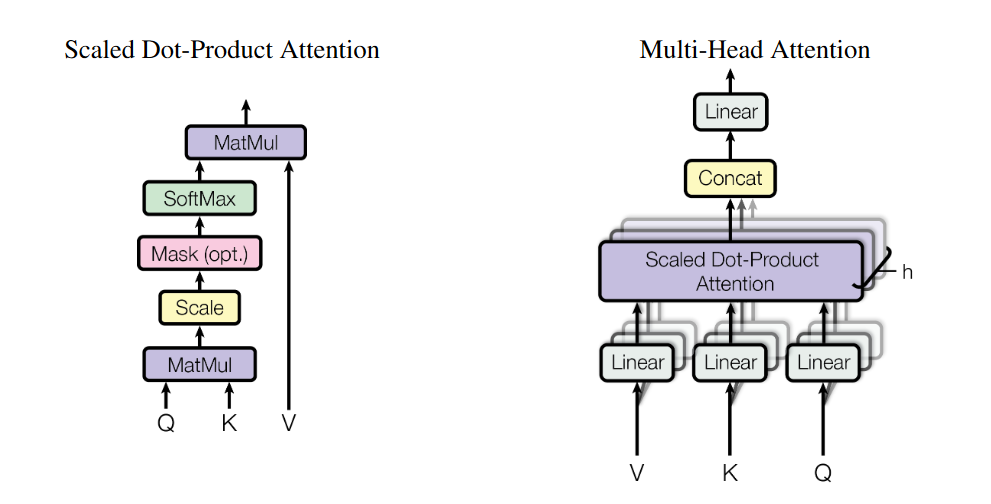

In [48]:
class MultiHeadedAttention(nn.Module):
    """A PyTorch module for Multi-Headed Attention.

    This module is used in the TransformerBlock to perform Multi-Headed Attention on the input tensor.

    Attributes:
        h (int): number of attention heads.
        W_q (nn.Linear): Linear layer for Q (query) projections.
        W_k (nn.Linear): Linear layer for K (key) projections.
        W_v (nn.Linear): Linear layer for V (value) projections.
        mask (torch.Tensor): Lower triangular mask to avoid attending to future tokens.

    Methods:
        forward(input: torch.Tensor) -> torch.Tensor:
        Performs Multi-Headed Attention on the input tensor.

    Raises:
        AssertionError: if the input tensor has incorrect dimensions.
        AssertionError: if it is not possible to divide the embeddings into h equal parts.
    """

    def __init__(self, h: int=8) -> None:
        """
        Initializes MultiHeadedAttention module.

        Args:
            h (int): number of attention heads.
        """
        assert NetworkConfig.c_embedding % h == 0, "Cannot create equal attention layers!"
        super().__init__()
        n_in = NetworkConfig.c_embedding
        self.W_q = nn.Linear(n_in, n_in)
        self.W_k = nn.Linear(n_in, n_in)
        self.W_v = nn.Linear(n_in, n_in)
        self.W_o = nn.Linear(n_in, n_in)
        self.h = h
        self.register_buffer("mask", torch.tril(torch.ones(1, 1, NetworkConfig.block_size, NetworkConfig.block_size)))
        self.dropout_layer = nn.Dropout(p=NetworkConfig.dropout)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Performs Multi-Headed Attention on the input tensor.

        Args:
            input (torch.Tensor): 3D tensor of shape (batch_size, timestamps, num_embeddings).

        Returns:
            torch.Tensor: 3D tensor of shape (batch_size, timestamps, num_embeddings).

        Raises:
            AssertionError: if the input tensor has incorrect dimensions.
        """
#         assert len(input.shape) == 3, f"Tensor should be of dimmensions (batch_size, timestamps, num_embeddings) but {input.shape=}"
        batch, timestamps, d_k = input.shape

        Q = self.W_q(input).view(batch, timestamps, self.h, d_k // self.h).transpose(1, 2)
        K = self.W_k(input).view(batch, timestamps, self.h, d_k // self.h).transpose(1, 2)
        V = self.W_v(input).view(batch, timestamps, self.h, d_k // self.h).transpose(1, 2)

        q_k = (Q @ K.transpose(2, 3)) * (1 / sqrt(d_k))
        q_k = q_k.masked_fill(self.mask[:, :, :timestamps, :timestamps] == 0, float('-inf'))

        probs = F.softmax(q_k, dim=-1)
        attention = (probs @ V).transpose(1,2).contiguous().view(batch, timestamps, d_k)
        attention = self.W_o(attention)

        return self.dropout_layer(attention)

# a = MultiHeadedAttention()
# print(a.forward(torch.randn(1024, 24, 64)).shape)

### Fully connected layer

Next step is to create fully connected layer following paper.

\begin{equation}
\mathbf{y} = \mathrm{FFN}(\mathbf{x}) = \mathrm{ReLU}(\mathbf{x}\mathbf{W_1}+\mathbf{b_1})\mathbf{W_2}+\mathbf{b_2}
\end{equation}

In [49]:
class FullyConnectedLayer(nn.Module):
    """
    A PyTorch module representing a fully connected layer in the Transformer network.

    Attributes:
        W_1 (nn.Linear): A PyTorch linear layer representing the weight matrix for the first linear transformation in the fully connected layer.
        W_2 (nn.Linear): A PyTorch linear layer representing the weight matrix for the second linear transformation in the fully connected layer.
        activation_fn (nn.ReLU): A PyTorch activation function applied after the first linear transformation.

    Methods:
        forward(input: torch.Tensor) -> torch.Tensor:
            Passes the input tensor through the fully connected layer and returns the output tensor.

    """
    def __init__(self, n_layers: int=2048) -> None:
        """
        Initializes a FullyConnectedLayer instance.

        Args:
            n_layers (int): The number of neurons in the hidden layer of the fully connected layer. Default is 2048.

        """
        super().__init__()
        self.W_1 = nn.Linear(NetworkConfig.c_embedding, n_layers)
#         nn.init.kaiming_normal_(self.W_1.weight, nonlinearity='relu')
        self.W_2 = nn.Linear(n_layers, NetworkConfig.c_embedding)
        self.activation_fn = nn.GELU()
        self.dropout_layer = nn.Dropout(p=NetworkConfig.dropout)
    
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Passes the input tensor through the fully connected layer and returns the output tensor.

        Args:
            input (torch.Tensor): A PyTorch tensor representing the input sequence.

        Returns:
            torch.Tensor: A PyTorch tensor representing the output sequence.

        """
        return self.dropout_layer(self.W_2(self.activation_fn(self.W_1(input))))


# fc = FullyConnectedLayer()
# fc.forward(torch.randn(1024, 24, 512)).shape

### Create attention block

Another step in the implementation is to concat multilayer attention and fully connected layer into a block, adding to it layer normalization and residual connections to keep informations about positional encodings.

Layer normalization follows this [paper](https://arxiv.org/pdf/1607.06450.pdf)

Unlike the original Transformer we are going to apply layer normalization before fully connected layer and multi-head attention, this approach was proposed by OpenAI researchers and gives slightly better results.

In [50]:
class TransformerBlock(nn.Module):
    """
    A PyTorch module representing a single block of a Transformer network.

    Attributes:
        norm_1 (nn.LayerNorm): A PyTorch layer normalization layer applied before the multi-headed attention layer.
        norm_2 (nn.LayerNorm): A PyTorch layer normalization layer applied before the fully connected layer.
        fully_connected (FullyConnectedLayer): A custom PyTorch module representing the fully connected layer in the Transformer block.
        m_attention (MultiHeadedAttention): A custom PyTorch module representing the multi-headed attention layer in the Transformer block.

    Methods:
        forward(input: torch.Tensor) -> torch.Tensor:
            Passes the input tensor through the Transformer block and returns the output tensor.

    """
    def __init__(self) -> None:
        """
        Initializes a TransformerBlock instance.

        """
        super().__init__()
        self.norm_1 = nn.LayerNorm(NetworkConfig.c_embedding)
        self.norm_2 = nn.LayerNorm(NetworkConfig.c_embedding)
        self.fully_connected = FullyConnectedLayer()
        self.m_attention = MultiHeadedAttention()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Passes the input tensor through the Transformer block and returns the output tensor.

        Args:
            input (torch.Tensor): A PyTorch tensor representing the input sequence.

        Returns:
            torch.Tensor: A PyTorch tensor representing the output sequence.

        """
        x = input + self.m_attention(self.norm_1(input))
        x = x + self.fully_connected(self.norm_2(x))
        return x


# b = TransformerBlock()
# b(torch.randn(1024, 24, 512)).shape

In [51]:
class Transformer(nn.Module):
    """
    A PyTorch module representing a Transformer network.

    Attributes:
        N (int): An integer representing the number of Transformer blocks to stack. Default value is 6.
        pos_enc_func (function): A function used to compute positional encodings for the input. Default function is
        `positional_encoding`.
        linear (nn.Linear): A PyTorch linear layer applied after the Transformer blocks to map the output to the vocabulary size.
        softmax (nn.Softmax): A PyTorch softmax layer applied after the linear layer to obtain the probability distribution over the vocabulary.
        layers (nn.ModuleList): A list of `N` identical `TransformerBlock` layers stacked on top of each other.

    Methods:
        forward(input: torch.Tensor, Y: torch.Tensor=None) -> torch.Tensor:
            Passes the input tensor through the Transformer network and returns the logits along with the optional loss.

    """
    def __init__(self, N: int=6, pos_enc_func=positional_encoding) -> None:
        """
        Initializes a Transformer instance.

        Args:
            N (int): An integer representing the number of Transformer blocks to stack. Default value is 6.
            pos_enc_func (function): A function used to compute positional encodings for the input. Default function is
            `positional_encoding`.

        """
        super().__init__()
        self.embedding = nn.Embedding(NetworkConfig.vocab_size, NetworkConfig.c_embedding)
        self.linear = nn.Linear(NetworkConfig.c_embedding, NetworkConfig.vocab_size)
        self.softmax = nn.Softmax(dim=-1)
        self.layers = nn.ModuleList([TransformerBlock() for _ in range(N)])
        self.pos_enc_func = pos_enc_func

    def forward(self, input: torch.Tensor, Y: torch.Tensor=None) -> torch.Tensor:
        """
        Passes the input tensor through the Transformer network and returns the logits along with the optional loss.

        Args:
            input (torch.Tensor): A PyTorch tensor representing the input sequence.
            Y (torch.Tensor): A PyTorch tensor representing the target sequence. Default is None.

        Returns:
            torch.Tensor: A PyTorch tensor representing the logits.
            None or torch.Tensor: The loss computed using cross entropy if the target sequence is provided, else None.

        """
        x = self.embedding(input)
        x = x + self.pos_enc_func(x, 'cuda')
        for layer in self.layers:
            x = layer(x)
        logits = self.linear(x)

        loss = None
        if Y is not None:
            loss = F.cross_entropy(logits.view(-1, NetworkConfig.vocab_size), Y.view(-1), ignore_index=-1)
        return logits, loss
    
    def _weights_init(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weights, mean=0.0, std=0.15)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Embedding):
            nn.init.normal_(m.weights, mean=0.0, std=0.15)
    
@torch.inference_mode()
def validation_loop(model, data: DataLoader) -> float:
    dataset_loss: float = .0
    for j, (X, Y) in enumerate(data):
        X = X.to('cuda')
        Y = Y.to('cuda')
        logits, loss = model(X, Y)
        dataset_loss += loss.item()
    return dataset_loss / (j + 1)


# t = Transformer()
# t.to('cuda')
# res = t(torch.randint(0, 27, (1024, 24), device='cuda'))
# res[0].shape

In [52]:
!nvidia-smi

Tue Feb 28 18:46:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    34W / 250W |   3873MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [53]:
from typing import List

class RDataset(Dataset):

    def __init__(self, data: List[str], characters: List[str], max_len: int) -> None:
        self.words = data
        self.characters = characters
        self.max_word_len = max_len
        self.stoi = {char:val + 1 for val, char in enumerate(self.characters)}
        self.itos = {val:char for char, val in self.stoi.items()}
    
    def __len__(self):
        return len(self.words)
    
    def encode(self, word: str) -> torch.Tensor:
        return torch.tensor([self.stoi[ch] for ch in word], dtype=torch.long, requires_grad=False)
    
    def __getitem__(self, index):
        word = self.words[index]
        index = self.encode(word)
        #pad the examples
        x = torch.zeros(self.max_word_len + 1, dtype=torch.long, requires_grad=False)
        y = torch.zeros_like(x, requires_grad=False)
        x[1:len(index) + 1] = index
        y[:len(index)] = index
        y[len(index) + 1:] = -1
        return x, y


def _isascii(string: str) -> bool:
    for ch in string:
        if ord(ch) not in range(97, 123): return False
    return True

with open("/kaggle/input/polish-names/polish_names.txt", "r") as file:
    names = [name.rstrip("\n") for name in filter(lambda name: _isascii(name.rstrip("\n")), file.readlines())]

data = [name for name in names if len(name) in range(3, 16)]
perm = torch.randperm(len(data))
data = [data[index] for index in perm.tolist()]
characters, m_len = sorted(set(''.join(names))), len(max(data, key=lambda name: len(name)))

print(m_len, sorted(set(''.join(names))))

train_split = int(len(data) * 0.8)
val_split = int(len(data) * 0.9)
training_data = data[:train_split]
validation_data = data[train_split:val_split]
test_data = data[val_split:]

training_data = RDataset(training_data, characters, m_len)
# validation_data = RDataset(validation_data, characters, m_len)
# test_data = RDataset(test_data, characters, m_len)

training_loader = DataLoader(training_data, batch_size=NetworkConfig.batch_size)
validation_loader = DataLoader(RDataset(validation_data, characters, m_len), batch_size=NetworkConfig.batch_size)
test_loader = DataLoader(RDataset(test_data, characters, m_len), batch_size=NetworkConfig.batch_size)
training_data[10]

15 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


(tensor([ 0, 19, 21, 13,  1, 25, 25,  1,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([19, 21, 13,  1, 25, 25,  1,  0, -1, -1, -1, -1, -1, -1, -1, -1]))

In [54]:
transformer = Transformer()
transformer.to('cuda')
optimizer = torch.optim.AdamW(transformer.parameters(), lr=0.0001)
best_val_loss: float = float('+inf')
best_train_loss: float = float('+inf')
val_loss: list = []
train_loss: list = []
epoch_counter: int = 1
model_weights: dict = transformer.state_dict()

In [65]:
transformer.load_state_dict(model_weights)

for i in range(100):
    epoch_train_loss: float = .0
    for j, (X, Y) in enumerate(training_loader):
        X = X.to('cuda')
        Y = Y.to('cuda')
        logits, loss = transformer.forward(X, Y)
        transformer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_loss.append(epoch_train_loss / (j + 1))
    epoch_val_loss: float = validation_loop(transformer, validation_loader)
    val_loss.append(epoch_val_loss)
    if (epoch_val_loss < best_val_loss):
        best_val_loss = epoch_val_loss
        model_weights = transformer.state_dict()
    print("\r", end='')
    print(f"Epoch {epoch_counter} | Train loss --> {epoch_train_loss / (j + 1):.4f} | Val loss --> {epoch_val_loss:.4f} |", end='', flush=True)
    epoch_counter += 1

Epoch 400 | Train loss --> 1.9133 | Val loss --> 2.1524 |

In [66]:
def plot_learning(title: str, x_label: str, y_label: str, epochs: List[int], **kwargs) -> None:
    plt.figure(figsize=(11,7))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(epochs, kwargs['train_loss'], label="Training loss")
    plt.plot(epochs, kwargs['validation_loss'], label="Validation loss")
    plt.legend()

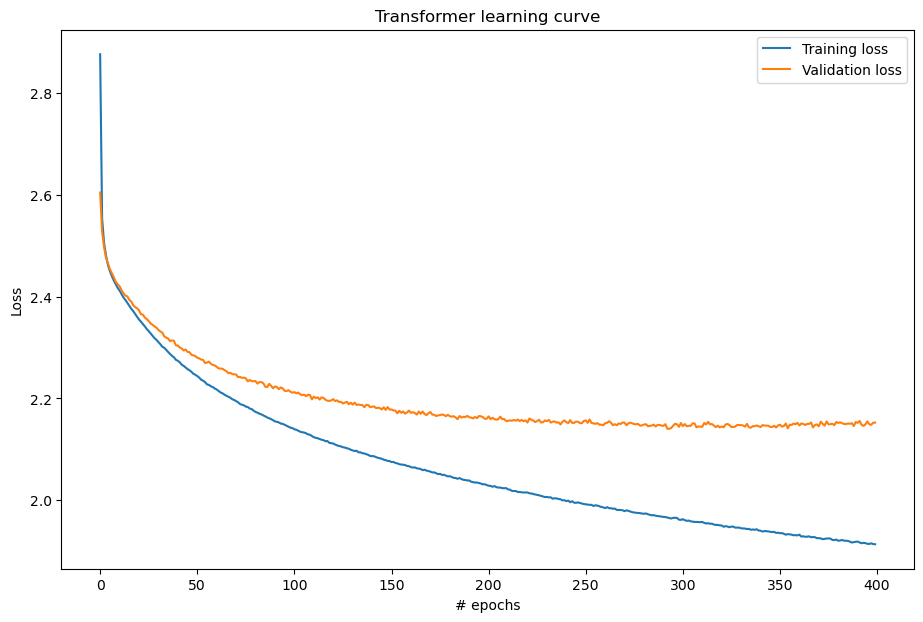

In [67]:
plot_learning("Transformer learning curve", "# epochs", "Loss", list(range(epoch_counter-1)), train_loss=train_loss, validation_loss=val_loss)

In [68]:
transformer.load_state_dict(model_weights)
print("Test set loss --> {loss:.4f}".format(loss=validation_loop(transformer, test_loader)))

Test set loss --> 2.1354


As we can see model is converging slowly, loss on test set is not the lowest, simply because we are probably underfitting the data, transformer model is big and complex model but our embedding is only of size 27x64, so there is not much space to learn for the model, another problem could be the quality of dataset, it wasn't prepared with caution and when I inspected some of the data some names were complete rubbish, those examples might add unwanted complexity and wariance to the model.